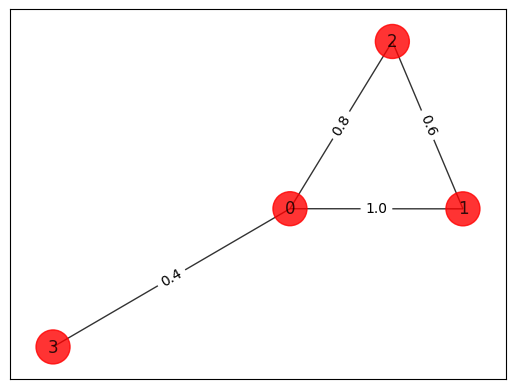

In [14]:
from collections import defaultdict
from typing import List, Tuple, Union

from dwave.system.samplers import DWaveSampler
from dwave.system.composites import EmbeddingComposite

import matplotlib.pyplot as plt

import networkx as nx

import numpy as np

# Generating a graph of 4 nodes

n = 4  # Number of nodes in graph
G = nx.Graph()
G.add_nodes_from(np.arange(0, n, 1))

weights   = [1.0, 0.8, 0.4, 0.6, 0.7]
edge_list = [(0, 1, weights[0]),
             (0, 2, weights[1]),
             (0, 3, weights[2]),
             (1, 2, weights[3])]

# tuple is (i,j,weight) where (i,j) is the edge
G.add_weighted_edges_from(edge_list)

colors = ["r" for node in G.nodes()]
pos = nx.spring_layout(G)


def draw_graph(G, colors, pos):
    default_axes = plt.axes(frameon=True)
    nx.draw_networkx(G, node_color=colors, node_size=600, alpha=0.8, ax=default_axes, pos=pos)
    edge_labels = nx.get_edge_attributes(G, "weight")
    nx.draw_networkx_edge_labels(G, pos=pos, edge_labels=edge_labels)


DISPLAY_GRAPH = True
if DISPLAY_GRAPH:
    draw_graph(G, colors, pos)
    plt.show()



In [15]:
def generate_Q(size: int, edges: List[Tuple[int, int, float]]) -> np.ndarray:
    """
    :param size: number of nodes in graph.
    :param edges: list of edges w. corresponding weight.
    :return: connectivity matrix of QUBO model, i.e. Q in x^TQx.
    """
    _Q = np.zeros(shape=(size, size), dtype=float)
    for _edge in edges:
        _i, _j, _w = _edge
        _Q[_i, _j] = _w
    return _Q

In [18]:
# ------- Set up our QUBO dictionary -------
# Get matrix from graph
init_Q = generate_Q(size=n, edges=edge_list)

# Initialize our Q matrix
Q = defaultdict(int)

# Update Q dictionary
for i in range(init_Q.shape[0]):
    for j in range(init_Q.shape[1]):
        Q[(i,j)]+= init_Q[i,j]

# ------- Run our QUBO on the QPU -------
# Set up QPU parameters
chainstrength = 80
numruns = 10

# Run the QUBO on the solver from your config file
sampler = EmbeddingComposite(DWaveSampler())
response = sampler.sample_qubo(Q,
                               chain_strength=chainstrength,
                               num_reads=numruns,
                               label='Example - Maximum Cut')


In [20]:
response

SampleSet(rec.array([([0, 0, 1, 0], 0., 3, 0.), ([1, 0, 0, 0], 0., 1, 0.),
           ([0, 0, 0, 1], 0., 1, 0.), ([0, 1, 0, 1], 0., 2, 0.),
           ([0, 1, 0, 0], 0., 1, 0.), ([0, 0, 0, 0], 0., 2, 0.)],
          dtype=[('sample', 'i1', (4,)), ('energy', '<f8'), ('num_occurrences', '<i8'), ('chain_break_fraction', '<f8')]), Variables([0, 1, 2, 3]), {'timing': {'qpu_sampling_time': 992.8, 'qpu_anneal_time_per_sample': 20.0, 'qpu_readout_time_per_sample': 58.74, 'qpu_access_time': 16748.77, 'qpu_access_overhead_time': 1877.23, 'qpu_programming_time': 15755.97, 'qpu_delay_time_per_sample': 20.54, 'total_post_processing_time': 211.0, 'post_processing_overhead_time': 211.0}, 'problem_id': '292ab9b3-7c6c-47e8-953a-f583349a7073', 'problem_label': 'Example - Maximum Cut'}, 'BINARY')

In [19]:
# ------- Print results to user -------
print('-' * 13)
print("Initial matrix:")
print('-' * 13)
print(f"{init_Q}\n")
print('-' * 35)

print("#"*8+" ANNEALING RESULTS "+"#"*8)
print('-' * int(n+16))
print(" "*int(n/2-3)+"State:"+" "*int(n/2-3)+" "*7+"Energy:")
print('-' * int(n+16))
for sample, E in response.data(fields=['sample','energy']):
    state = "|"
    for k,v in sample.items():
        state += str(v)
    state += ">"
    print(str(state)+" "*7+str(E))
print('-' * 55)
print("With lowest energy state corresponding to alignement:")
print('-' * 55)
best_state = []
for val in list(response.first.sample.values()):
    best_state.append(val)
print(best_state)

-------------
Initial matrix:
-------------
[[0.  1.  0.8 0.4]
 [0.  0.  0.6 0. ]
 [0.  0.  0.  0. ]
 [0.  0.  0.  0. ]]

-----------------------------------
######## ANNEALING RESULTS ########
--------------------
State:       Energy:
--------------------
|0010>       0.0
|1000>       0.0
|0001>       0.0
|0101>       0.0
|0100>       0.0
|0000>       0.0
-------------------------------------------------------
With lowest energy state corresponding to alignement:
-------------------------------------------------------
[0, 0, 1, 0]
